In [ ]:
%%bash
rm -rf "sample_data" "images" "masks"
cp -r "/content/drive/MyDrive/imp documents/sattelite" "sattelite"              # make copy of data
mkdir 'images' 'masks'                                                          # make folders for images and masks
python -m pip install -qq git+https://github.com/tensorflow/examples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
parent_directory='sattelite/DubaiDataset'                                       # train directory
for index,subfolder in  enumerate(os.listdir(parent_directory)):                # get folder from main directory
  if os.path.isdir(os.path.join(parent_directory,subfolder)):                   # if not a folder
    for folder in os.listdir(os.path.join(parent_directory,subfolder)):          # get folder from sub-folder
      for files in os.listdir(os.path.join(parent_directory,subfolder,folder)): # get files from folder
        files_new_name=files.split('.')[0]+f'_tile_{index}.'+files.split('.')[-1]
        os.rename(os.path.join(parent_directory,subfolder,folder,files),os.path.join(folder,files_new_name))
!rm -Rf "sattelite"                                                             # remove old directory

In [ ]:
# Load Data

images=tf.keras.utils.image_dataset_from_directory('images',labels=None,label_mode='int',class_names=None,color_mode='rgb',
                                                   batch_size=128,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                   interpolation='bilinear',subset=None)
masks=tf.keras.utils.image_dataset_from_directory('masks',labels=None,label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=128,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                  interpolation='bilinear',subset=None)
# see data counts
print('Images counts:',images.cardinality())
print('Masks counts:',masks.cardinality())
# zip data
data=tf.data.Dataset.zip((images,masks))
# # split data into training and test
# train=data.take(int(72*0.9))
# test=data.skip(int(72*0.9)).take(int(72*0.1))

Found 72 files belonging to 1 classes.
Found 72 files belonging to 1 classes.
Images counts: tf.Tensor(1, shape=(), dtype=int64)
Masks counts: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
# make rescle inmages
rescaler=tf.keras.layers.Rescaling(1./255.,offset=0,name='rescaling_01',input_shape=(256,256,3))# rescaler
data=data.map(lambda x,y: (rescaler(x),rescaler(y)))

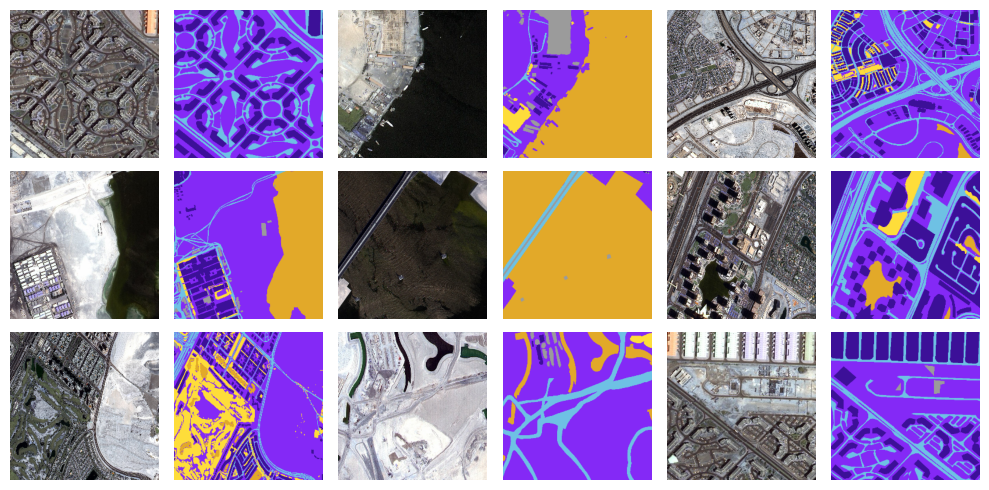

In [ ]:
# for sample_images in images.take(1,name='sample_images'):break
# for sample_masks in masks.take(1,name='sample_masks'):break
for sample_images,sample_masks in data.take(1):break
plot_number:int=1
plt.figure(figsize=(10,5))
for image,mask in zip(sample_images.numpy()[:9],sample_masks.numpy()[:9]):
  plt.subplot(3,6,plot_number)
  plt.imshow(image,cmap='gray')
  plt.axis('off')
  plt.subplot(3,6,plot_number+1)
  plt.imshow(mask,cmap='gray')
  plt.axis('off')
  plot_number+=2
plt.tight_layout()
plt.show()

In [ ]:
#see images and mask - shape and pixel ranges
print('Image batch shape:',sample_images.shape)
print('mask batch shape:',sample_masks.shape)
print('Image batch maximum value:',tf.reduce_max(sample_images),'and minimum value:',tf.reduce_min(sample_images))
print('Image batch maximum value:',tf.reduce_max(sample_images),'and minimum value:',tf.reduce_min(sample_images))
print('see pixel values (if binary mask):',set(sample_masks.numpy().flatten()))

Image batch shape: (72, 256, 256, 3)
mask batch shape: (72, 256, 256, 3)
Image batch maximum value: tf.Tensor(1.0, shape=(), dtype=float32) and minimum value: tf.Tensor(0.0, shape=(), dtype=float32)
Image batch maximum value: tf.Tensor(1.0, shape=(), dtype=float32) and minimum value: tf.Tensor(0.0, shape=(), dtype=float32)
see pixel values (if binary mask): {0.5176471, 0.16078432, 0.53937274, 0.96470594, 0.4628514, 0.9198731, 0.43137258, 0.7568628, 0.8941177, 0.48439896, 0.39049864, 0.9375029, 0.23529413, 0.0627451, 0.59607846, 0.4816981, 0.60874844, 0.68687344, 0.92122, 0.757148, 0.39390942, 0.28451073, 0.90950125, 0.58011645, 0.2770527, 0.9032563, 0.80406094, 0.17904909, 0.063814715, 0.64976406, 0.2727446, 0.9133696, 0.9211726, 0.9446101, 0.18680236, 0.5696196, 0.9009818, 0.517084, 0.12137925, 0.8586442, 0.8742692, 0.7258317, 0.9601972, 0.86643773, 0.52396595, 0.8872472, 0.4888097, 0.40311635, 0.49142352, 0.692423, 0.46195424, 0.6770421, 0.40751088, 0.6809484, 0.47282577, 0.44460285,

In [ ]:
# define downsampler -----------------------------------------------------------
# load base model - MobileNet Version 2
input_shape=(256,256,3)
base_model=tf.keras.applications.MobileNetV2(input_shape=(input_shape[0]//2,input_shape[1]//2,input_shape[2]),include_top=False)

# use the activations of these layers (as outputs)
layer_names=[
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# get model layer by its name
base_model_output_layers=[base_model.get_layer(name).output for name in layer_names]
# create the feature extraction model (downsampler / encoder)
downsampler=tf.keras.Model(inputs=base_model.input,outputs=base_model_output_layers)
# freeze model
downsampler.trainable=True
# see model summary
#downsampler.summary(line_length=140,positions= None,print_fn=None,expand_nested=False,
#                    show_trainable=False,layer_range=None)
# # make model plot
# tf.keras.utils.plot_model(downsampler,to_file='downsampler.png',show_shapes=True,show_dtype=False,
#                           show_layer_names=True,rankdir='TB',expand_nested=False,dpi=96,
#                           layer_range=None,show_layer_activations=False,show_trainable=False)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# define upsampler -------------------------------------------------------------
# the decoder/upsampler is simply a series of upsample blocks implemented

# make upsampler layers list -> pix2pix.upsample
# pix2pix.upsample -> Conv2DTranspose => Batchnorm => Dropout => Relu
#     Args:
#        filters: number of filters
#        size: filter size
#        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
#        apply_dropout: If True, adds the dropout layer
# Returns: -> Upsample Sequential Model
upsampler_layers=[
    pix2pix.upsample(filters=512,size=3,norm_type='batchnorm',apply_dropout=False),# 4x4 -> 8x8
    pix2pix.upsample(filters=256,size=3,norm_type='batchnorm',apply_dropout=False),# 8x8 -> 16x16
    pix2pix.upsample(filters=128,size=3,norm_type='batchnorm',apply_dropout=False),# 16x16 -> 32x32
    pix2pix.upsample(filters=64,size=3,norm_type='batchnorm',apply_dropout=False), # 32x32 -> 64x64
    ]


In [ ]:
# define modified U-Net model --------------------------------------------------
# paper -> https://arxiv.org/abs/1505.04597
# U-Net: Convolutional Networks for Biomedical Image Segmentation
#inputs=base_model.input#or #inputs=tf.keras.layers.Input(shape=input_shape,batch_size=None,name=None)
inputs=tf.keras.layers.Input(shape=input_shape,batch_size=None,name=None)       # single channel
uNetx=tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2))(inputs)   # downlsample to (128,128)
uNet_downsampler_outputs=downsampler(uNetx)# 5 outputs -> KerasTensor, shapes = (None,64,64,96), (None,32,32,144), (None,16,16,192)
# (None,8,8,576), (None,4,4,320)
uNetx=uNet_downsampler_outputs[-1]# get last outputs -> < KerasTensor, shapes = (None, 4, 4, 320)
# upsampling and establishing the connections
for upsampler_layer,downsampler_layer_out in zip(upsampler_layers,uNet_downsampler_outputs[:-1][::-1]):#uNet_downsampler_outputs[:-1][::-1]
# leaving last and reversing output connections
  uNetx=upsampler_layer(uNetx)# upsample layer
  uNetx=tf.keras.layers.Concatenate()([uNetx,downsampler_layer_out])
# define output layer
uNetx=tf.keras.layers.Conv2DTranspose(filters=input_shape[2],kernel_size=3,strides=2,padding='same',activation='sigmoid')(uNetx)# 64x64 -> 128x128
outputs=tf.keras.layers.UpSampling2D(size=(2,2),data_format=None,interpolation='bilinear')(uNetx)# 128x128 -> 256x256
# build U-Net model
uNet=tf.keras.Model(inputs=inputs,outputs=outputs,name='custom_UNET')

# compile model
uNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-7,amsgrad=False,name='adam'),
              loss=tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error'),
              metrics=['mean_squared_error'])

In [ ]:
# plot model -------------------------------------------------------------------
tf.keras.utils.plot_model(uNet,to_file='uNet.png',show_shapes=True,show_dtype=False,show_layer_names=True,rankdir='TB',expand_nested=False,
                          dpi=96,layer_range=None,show_layer_activations=False,show_trainable=False)

In [ ]:
 # early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,
                                                mode='auto',baseline=None,restore_best_weights=True,start_from_epoch=0)
# make model train
history=uNet.fit(data,batch_size=None,epochs=10_000,verbose=2,callbacks=[early_stopping],validation_split=0,validation_data=data,
                 shuffle=True,class_weight=None,sample_weight=None,initial_epoch=0,steps_per_epoch=None,
                 max_queue_size=10,workers=1,use_multiprocessing=False)

Epoch 1/10000
1/1 - 40s - loss: 0.2887 - mean_squared_error: 0.1089 - val_loss: 0.2709 - val_mean_squared_error: 0.1023 - 40s/epoch - 40s/step
Epoch 2/10000
1/1 - 19s - loss: 0.2694 - mean_squared_error: 0.1017 - val_loss: 0.2609 - val_mean_squared_error: 0.1018 - 19s/epoch - 19s/step
Epoch 3/10000
1/1 - 26s - loss: 0.2560 - mean_squared_error: 0.0983 - val_loss: 0.2518 - val_mean_squared_error: 0.1018 - 26s/epoch - 26s/step
Epoch 4/10000
1/1 - 20s - loss: 0.2461 - mean_squared_error: 0.0967 - val_loss: 0.2451 - val_mean_squared_error: 0.1020 - 20s/epoch - 20s/step
Epoch 5/10000
1/1 - 20s - loss: 0.2383 - mean_squared_error: 0.0953 - val_loss: 0.2398 - val_mean_squared_error: 0.1021 - 20s/epoch - 20s/step
Epoch 6/10000
1/1 - 20s - loss: 0.2305 - mean_squared_error: 0.0933 - val_loss: 0.2352 - val_mean_squared_error: 0.1018 - 20s/epoch - 20s/step
Epoch 7/10000
1/1 - 21s - loss: 0.2222 - mean_squared_error: 0.0904 - val_loss: 0.2312 - val_mean_squared_error: 0.1013 - 21s/epoch - 21s/step

In [ ]:
pd.DataFrame(history.history)

loss  mean_squared_error  val_loss  val_mean_squared_error
0   0.288679            0.108855  0.270875                0.102348
1   0.269427            0.101692  0.260891                0.101750
2   0.256000            0.098257  0.251844                0.101759
3   0.246085            0.096667  0.245097                0.102041
4   0.238256            0.095324  0.239811                0.102129
5   0.230493            0.093274  0.235245                0.101834
6   0.222236            0.090371  0.231222                0.101275
7   0.213889            0.086796  0.227626                0.100828
8   0.205495            0.082663  0.224165                0.100574
9   0.197194            0.078452  0.221444                0.100932
10  0.190223            0.074910  0.222330                0.103855
11  0.185394            0.072443  0.229952                0.111040
12  0.181113            0.070663  0.242733                0.120938
13  0.176604            0.069156  0.255404                0.130596
14  0.172107            0.067710  0.267162                0.139812
15  0.167867            0.066170  0.277197                0.147752
16  0.164179            0.064745  0.287722                0.155890
17  0.160819            0.063050  0.299007                0.164413
18  0.157462            0.060952  0.308808                0.171545
19  0.153933            0.058685  0.318571                0.178770

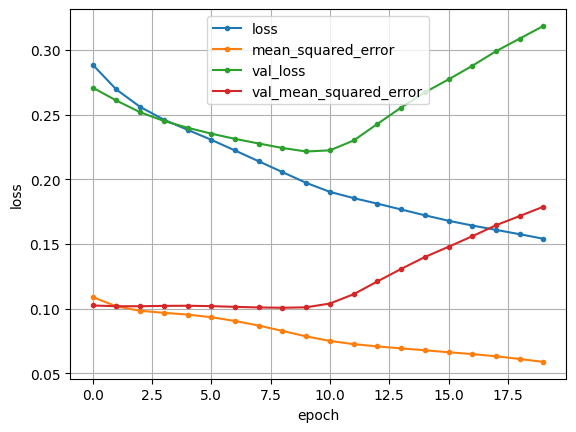

In [ ]:
# make plot losses
pd.DataFrame(history.history).plot(marker='.')
plt.grid(),plt.xlabel('epoch'),plt.ylabel('loss')
plt.show()

In [ ]:
# evaluate model on testing data
test_results=uNet.evaluate(data,batch_size=None,verbose='auto',sample_weight=None,steps=None,callbacks=None,max_queue_size=10,workers=1,
                           use_multiprocessing=False,return_dict=True)
# see results (dictionary)
test_results

1/1 [==============================] - 5s 5s/step - loss: 0.2214 - mean_squared_error: 0.1009


{'loss': 0.2214435189962387, 'mean_squared_error': 0.10093221068382263}

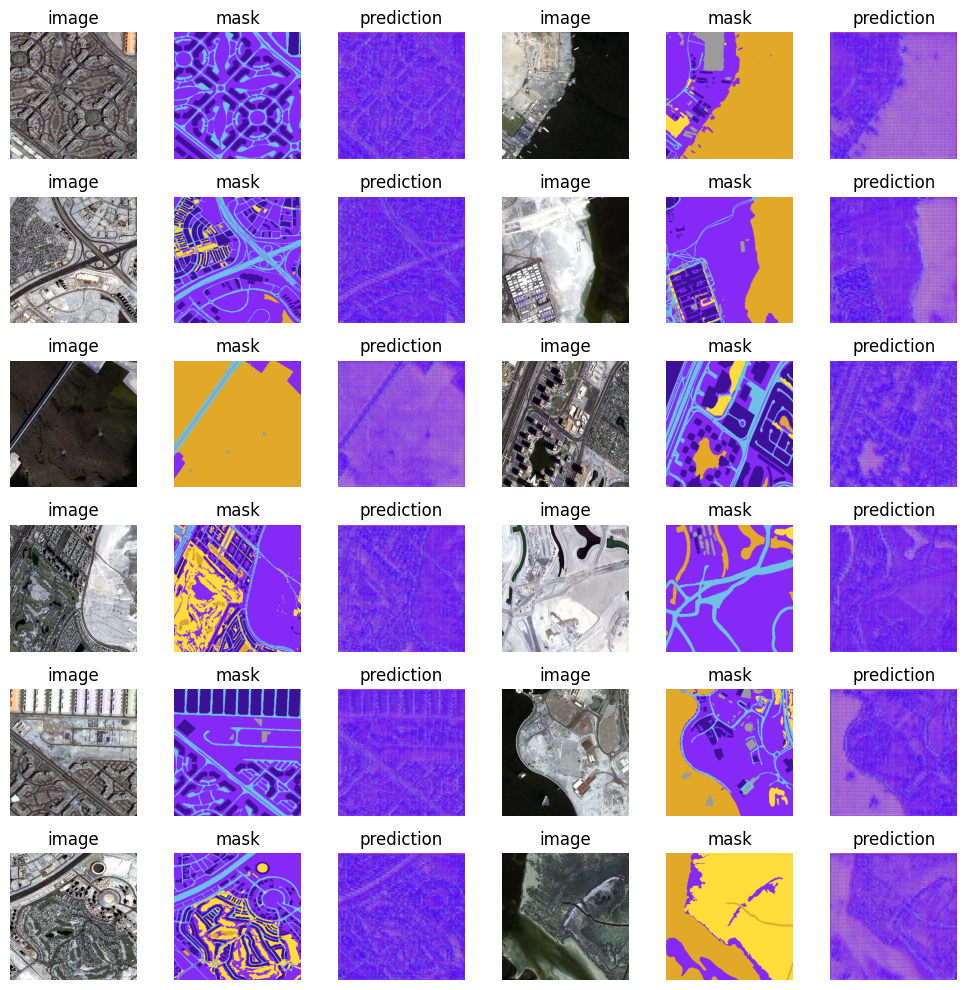

In [ ]:
# get sample image and mask
for sample_images,sample_masks in data.take(1):break                            # batch of 128
plot_number:int=1                                                               # set current plot number
total_samples:int=12                                                            # total samples to take (must be less than batch size)
plt.figure(figsize=(10,10))                                                      # make plot
for image,mask in zip(sample_images.numpy()[:total_samples],sample_masks.numpy()[:total_samples]):
  plt.subplot(6,6,plot_number)                                                  # make subplot for images
  plt.imshow(image,cmap='gray')                                                 # make plot image
  plt.axis('off')                                                               # set axis off
  plt.title('image')                                                            # add title
  plt.subplot(6,6,plot_number+1)                                                # make subplot for mask
  plt.imshow(mask,cmap='gray')                                                  # make plot mask
  plt.axis('off')                                                               # set axis off
  plt.title('mask')                                                             # add title
  plt.subplot(6,6,plot_number+2)                                                # make subplot for mask
  plt.imshow(tf.squeeze(uNet.predict(tf.expand_dims(image,axis=0),verbose=0)),cmap='gray')# make plot predicted mask
  plt.axis('off')                                                               # set axis off
  plt.title('prediction')                                                       # add title
  plot_number+=3                                                                # update current plot number
plt.tight_layout()                                                              # set plot layout
plt.show()

In [ ]:
uNet.save('semantic_segmentation',overwrite=True,save_format=None)

In [ ]:
!zip -r -qq "semantic_segmentation.zip" "semantic_segmentation"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('semantic_segmentation.zip')                                       # download model zip file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%cp "/content/semantic_segmentation" "/content/drive/MyDrive/output"

cp: -r not specified; omitting directory '/content/semantic_segmentation'
